# Imports

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')
# pd.options.display.max_columns = None

import pandas as pd
import numpy as np
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Models
from sklearn.model_selection import train_test_split


# Retrieve data
import yfinance as yf

# Scaling the data
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Create RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Retrieve data

In [2]:
# Retrieve data from ticker
ticker = "AAPL"  #
data = yf.Ticker(ticker)

# Download data history
historical_data = data.history(period="10y")
historical_data.reset_index(inplace=True)

# Keep date as index
historical_data.set_index(keys = 'Date', inplace=True)
historical_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-26 00:00:00-04:00,227.300003,228.500000,225.410004,227.520004,36636700,0.0,0.0
2024-09-27 00:00:00-04:00,228.460007,229.520004,227.300003,227.789993,34026000,0.0,0.0
2024-09-30 00:00:00-04:00,230.039993,233.000000,229.649994,233.000000,54541900,0.0,0.0
2024-10-01 00:00:00-04:00,229.520004,229.649994,223.740005,226.210007,62940000,0.0,0.0
2024-10-02 00:00:00-04:00,225.889999,226.110001,223.029999,224.464996,8006652,0.0,0.0


# Explore data


<span style="font-family:Comic Sans MS; color:red">Let's quickly explore the data ! </span>


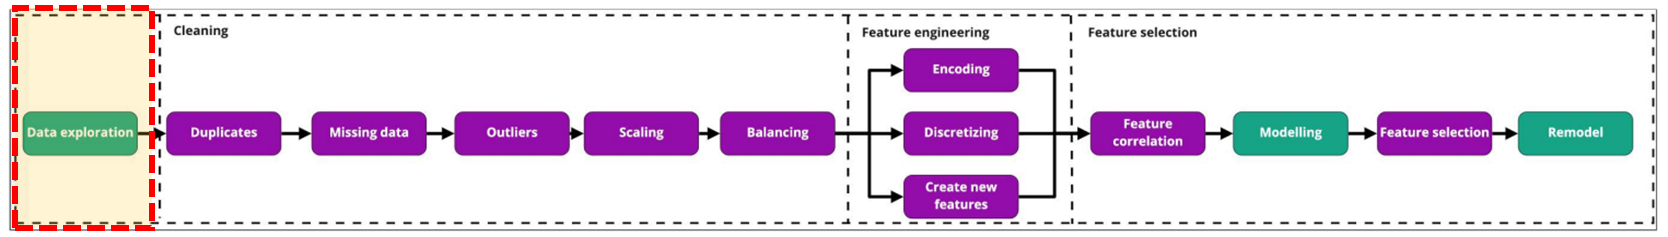


In [3]:
# Shape
historical_data.shape

(2517, 7)

In [4]:
# Columns
historical_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [5]:
# Statistics
historical_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000,2517.000000
mean,89.069822,90.026411,88.168973,89.139474,1.210457e+08,0.002994,0.001589
std,62.614262,63.278324,61.987225,62.663540,6.949041e+07,0.024116,0.079729
min,20.642054,21.025078,20.520501,20.720039,8.006652e+06,0.000000,0.000000
25%,33.027887,33.214115,32.825366,33.009270,7.417280e+07,0.000000,0.000000
50%,54.584805,55.104914,54.010368,54.398663,1.034728e+08,0.000000,0.000000
75%,146.720521,148.572602,145.454291,146.898346,1.478228e+08,0.000000,0.000000
max,236.206595,236.955728,232.820515,234.548523,6.488252e+08,0.250000,4.000000


In [6]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-02 00:00:00-04:00 to 2024-10-02 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB


# Data Cleaning and Feature Engineering


<span style="font-family:Comic Sans MS; color:red">Let's clean the data ! </span>



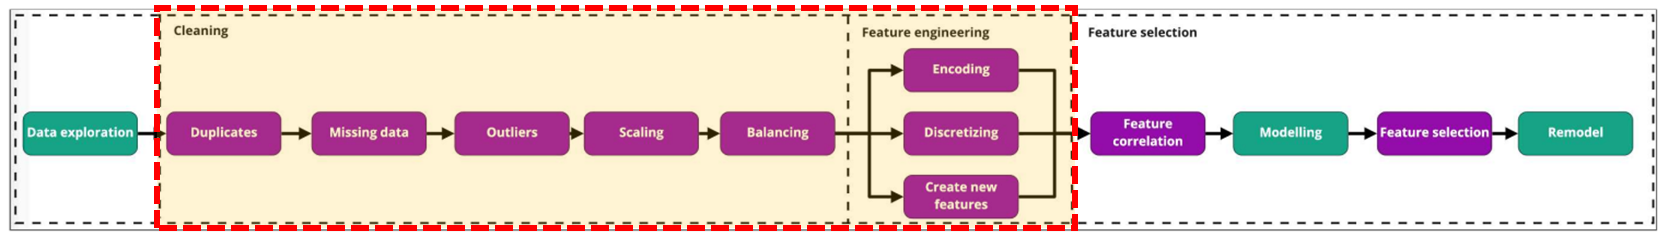


## Duplicates


In [7]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(historical_data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {historical_data.duplicated().sum()}")

# Remove duplicates
# data = data.drop_duplicates() 


Number of rows : 2517
Number of duplicated rows : 0


## Missing data



In [8]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(historical_data)
missing_data

Series([], dtype: float64)

In [9]:
# historical_data.dropna(axis = 0, subset='Close_plus_1', inplace=True)

In [10]:
missing_data = get_missing_data(historical_data)
missing_data

Series([], dtype: float64)

## Outliers


### Identificate numerical columns



In [11]:
# Extract numerical columns from original dataset
numerical_columns = historical_data.select_dtypes(include = np.number).columns
numerical_columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

### Visual checks for outliers


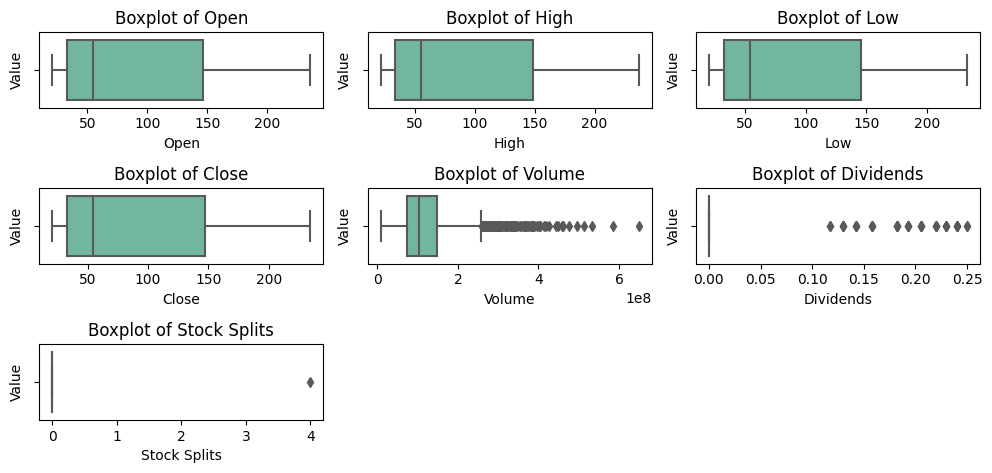

In [12]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=historical_data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

<span style="font-family:Comic Sans MS; color:red">Plot a specific boxplot. Insert column name below : </span>
    

In [13]:
specific_column = 'Volume'

Text(0, 0.5, 'Value')

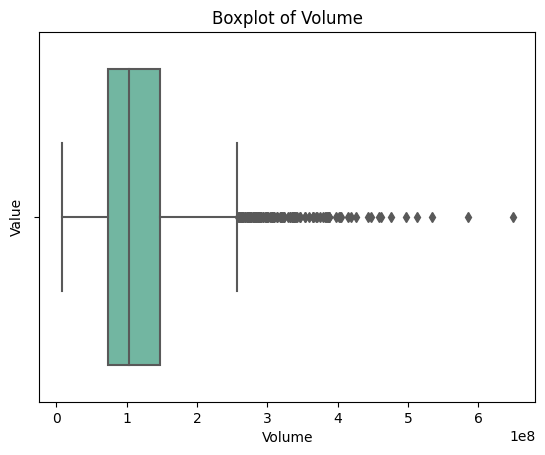

In [14]:
# Plot a specific boxplot
sns.boxplot(x=historical_data[specific_column], palette='Set2')
plt.title(f'Boxplot of {specific_column}')
plt.xlabel(specific_column)
plt.ylabel('Value')

### Numerical check for outliers


<span style="font-family:Comic Sans MS; color:red"> Let's numerically extract the columns with outliers ! </span>


In [15]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in numerical_columns: 
    # Calculate IQR
    iqr_value = iqr(historical_data[col])

    #Calculate 1st quartile
    q1 = np.percentile(historical_data[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(historical_data[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = historical_data[col] < outlier_lim_low
    number_outliers_low = len(historical_data[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = historical_data[col] > outlier_lim_high
    number_outliers_high = len(historical_data[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
    
#     print(f'------------------  {col}  -----------------------')
#     print(f'Number of outliers : {number_outliers_total}')
#     print('---------------------------------------------------')
    
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)
        
        

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITH outliers :  </span>


In [16]:
numerical_columns_w_outliers

['Volume', 'Dividends', 'Stock Splits']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITHOUT outliers :  </span>


In [17]:
numerical_columns_no_outliers

['Open', 'High', 'Low', 'Close']

## Scaling the data


### Scaling numerical columns WITH outliers


<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>

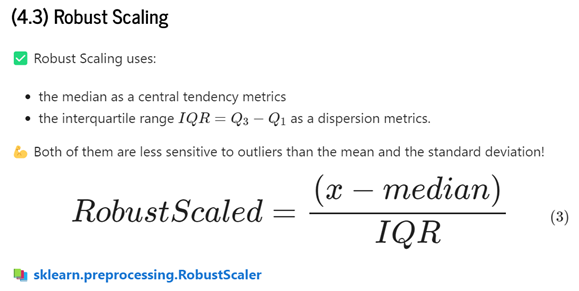


In [18]:
# Describe columns with outliers
historical_data[numerical_columns_w_outliers].describe()

,Volume,Dividends,Stock Splits
count,2.517000e+03,2517.000000,2517.000000
mean,1.210457e+08,0.002994,0.001589
std,6.949041e+07,0.024116,0.079729
min,8.006652e+06,0.000000,0.000000
25%,7.417280e+07,0.000000,0.000000
50%,1.034728e+08,0.000000,0.000000
75%,1.478228e+08,0.000000,0.000000
max,6.488252e+08,0.250000,4.000000


In [19]:
# Instantiate the robust scaler
rb_scaler = RobustScaler() 

# Fit the robust scaler on X_train
rb_scaler.fit(historical_data[numerical_columns_w_outliers]) 

# Transform X_train and X_test through the fitted robust scaler
historical_data[numerical_columns_w_outliers] = rb_scaler.transform(historical_data[numerical_columns_w_outliers])

In [20]:
# Describe columns with outliers after robust scaling
historical_data[numerical_columns_w_outliers].describe()

,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000
mean,0.238600,0.002994,0.001589
std,0.943522,0.024116,0.079729
min,-1.296214,0.000000,0.000000
25%,-0.397828,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.602172,0.000000,0.000000
max,7.404649,0.250000,4.000000


### Scaling numerical columns with NO outliers




<span style="font-family:Comic Sans MS; color:red">We consider using MinMax scaling for columns WITH NO outliers !  </span>


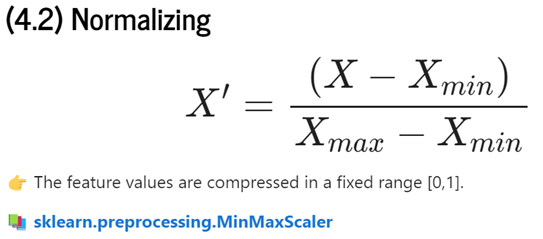


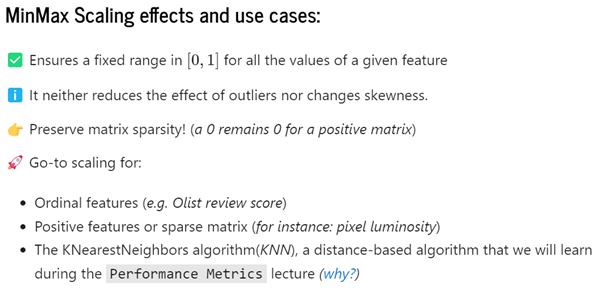


In [21]:
# Describe columns with NO outliers (BEFORE SCALING)
print('Description of the numerical columns WITHOUT outliers (BEFORE SCALING)')
historical_data[numerical_columns_no_outliers].describe()

Description of the numerical columns WITHOUT outliers (BEFORE SCALING)


,Open,High,Low,Close
count,2517.000000,2517.000000,2517.000000,2517.000000
mean,89.069822,90.026411,88.168973,89.139474
std,62.614262,63.278324,61.987225,62.663540
min,20.642054,21.025078,20.520501,20.720039
25%,33.027887,33.214115,32.825366,33.009270
50%,54.584805,55.104914,54.010368,54.398663
75%,146.720521,148.572602,145.454291,146.898346
max,236.206595,236.955728,232.820515,234.548523


Histograms of the numerical columns WITHOUT outliers (BEFORE SCALING)


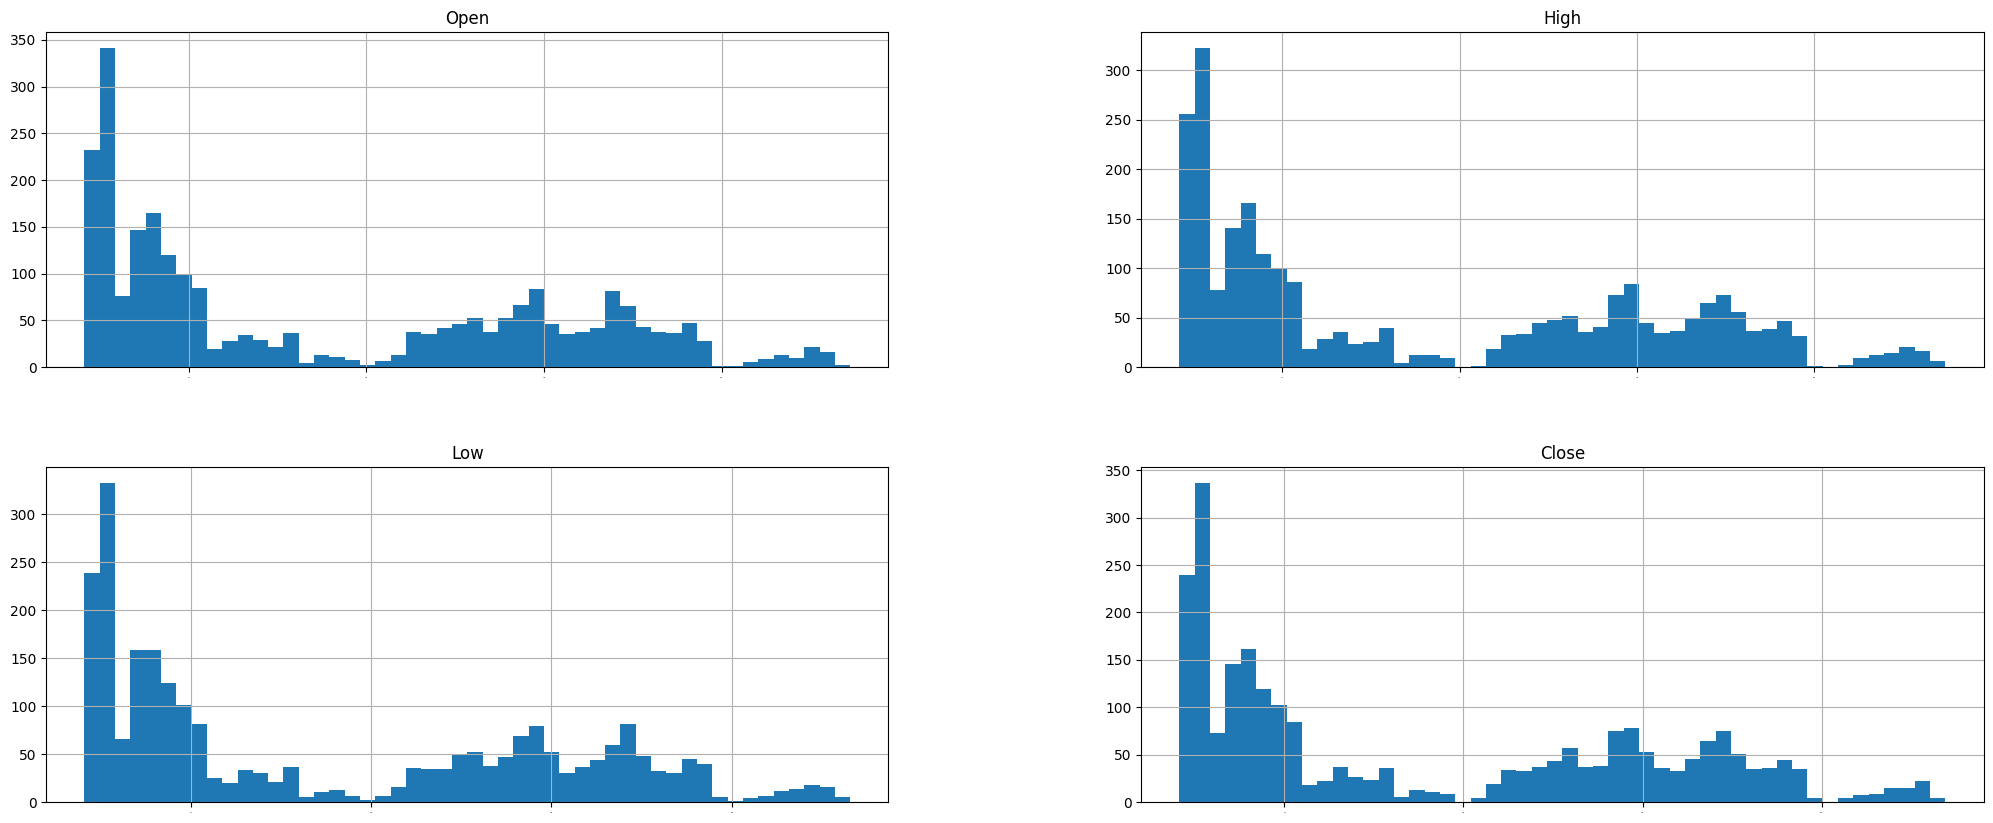

In [22]:
# Data histograms
print("Histograms of the numerical columns WITHOUT outliers (BEFORE SCALING)")
historical_data[numerical_columns_no_outliers].hist(bins = 50, figsize = (25,10), xlabelsize=0)
plt.show()


In [23]:
# Display description of each columns with no outliers (BEFORE SCALING)
print("Description of the columns without outliers (BEFORE SCALING)")
for col in numerical_columns_no_outliers:
    print(f"----------------- {col} --------------")
    print(historical_data[col].describe())
    print('---------------------------------------\n')

Description of the columns without outliers (BEFORE SCALING)
----------------- Open --------------
count    2517.000000
mean       89.069822
std        62.614262
min        20.642054
25%        33.027887
50%        54.584805
75%       146.720521
max       236.206595
Name: Open, dtype: float64
---------------------------------------

----------------- High --------------
count    2517.000000
mean       90.026411
std        63.278324
min        21.025078
25%        33.214115
50%        55.104914
75%       148.572602
max       236.955728
Name: High, dtype: float64
---------------------------------------

----------------- Low --------------
count    2517.000000
mean       88.168973
std        61.987225
min        20.520501
25%        32.825366
50%        54.010368
75%       145.454291
max       232.820515
Name: Low, dtype: float64
---------------------------------------

----------------- Close --------------
count    2517.000000
mean       89.139474
std        62.663540
min        20.720

In [24]:
# We choose to focus on only ONE column (at first)
numerical_columns_no_outliers = 'Close'

# Instantiate the scaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on entire data
minmax_scaler.fit(historical_data['Close'].values.reshape(-1,1)) 

# Transform entire data through the fitted scaler
historical_data[numerical_columns_no_outliers] = minmax_scaler.transform(historical_data['Close'].values.reshape(-1,1))

# Message displayed
print("SCALING DONE !")

SCALING DONE !


In [25]:
# If there is only one column considered (string). This code is ignored otherwise.
if type(numerical_columns_no_outliers) == str:
    numerical_columns_no_outliers_list = []
    numerical_columns_no_outliers_list.append(numerical_columns_no_outliers)
    numerical_columns_no_outliers = numerical_columns_no_outliers_list
    
# Display description of each columns with no outliers (AFTER SCALING)
print("Description of the columns without outliers (AFTER SCALING)") 
for col in numerical_columns_no_outliers:
    print(f"----------------- {col} --------------")
    print(historical_data[col].describe())
    print('---------------------------------------\n')

Description of the columns without outliers (AFTER SCALING)
----------------- Close --------------
count    2517.000000
mean        0.319973
std         0.293055
min         0.000000
25%         0.057472
50%         0.157503
75%         0.590091
max         1.000000
Name: Close, dtype: float64
---------------------------------------



## Balancing


<span style="font-family:Comic Sans MS; color:red"> NOT PERFORMED ! </span>



## Encoding


<span style="font-family:Comic Sans MS; color:red"> NOT PERFORMED ! </span>



## Discretizing


<span style="font-family:Comic Sans MS; color:red"> NOT PERFORMED ! </span>



## Create new features


<span style="font-family:Comic Sans MS; color:red"> NOT PERFORMED ! </span>



# Feature selection


<span style="font-family:Comic Sans MS; color:red">Let's clean the data ! </span>



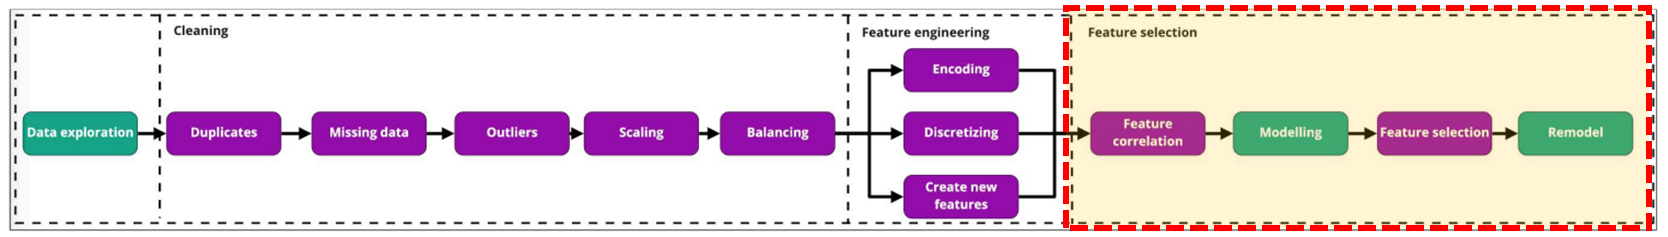


## Feature correlation


<span style="font-family:Comic Sans MS; color:red"> NOT PERFORMED ! </span>



## Modeling


### Define data


In [26]:
# We focus on 1 unique column
data = historical_data['Close']

print("We'll work with the following data for the predictions.")
data

We'll work with the following data for the predictions.


Date
2014-10-02 00:00:00-04:00    0.006807
2014-10-03 00:00:00-04:00    0.006516
2014-10-06 00:00:00-04:00    0.006516
2014-10-07 00:00:00-04:00    0.005613
2014-10-08 00:00:00-04:00    0.007741
                               ...   
2024-09-26 00:00:00-04:00    0.967130
2024-09-27 00:00:00-04:00    0.968393
2024-09-30 00:00:00-04:00    0.992758
2024-10-01 00:00:00-04:00    0.961004
2024-10-02 00:00:00-04:00    0.952843
Name: Close, Length: 2517, dtype: float64

In [27]:
# Keep/record the index (datetime) and reshape it also. Useful for final visualization.
date_mesure = data.index.values.reshape(-1,1)
print(date_mesure.shape)
print("The date time info (index) has been reshaped.")

(2517, 1)
The date time info (index) has been reshaped.


In [28]:
# Let's reshape the data
print(data.shape)
data = data.values.reshape(-1, 1)
print(data.shape)
print("The data values have been reshaped.")

(2517,)
(2517, 1)
The data values have been reshaped.


### Define train data and test data


In [29]:
# Create train data and test data
# Define size of train data
data_percentage = 0.8
train_size = int(len(data) * data_percentage)
print("Train data size calculated.")

# Create train data and test data
train_data = data[:train_size]
test_data = data[train_size:]
print('Train data and test data have been created.')

# Create train data dates and test data dates (datetime)
train_dates = date_mesure[:train_size]
test_dates = date_mesure[train_size:]
print("The dates for train data and test data have been separated.")

Train data size calculated.
Train data and test data have been created.
The dates for train data and test data have been separated.


### Define X and y


In [30]:
# Function to create sequences (X) and targets (y)
def create_dataset(dataset, time_step=60, dates=None):
    X, y = [], []
    time = []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])       
        y.append(dataset[i, 0])
        time.append(dates[i,0])
    return np.array(X), np.array(y), np.array(time)


# Create train datasets (X and y) and test datasets (X and y) and associated dates
# time_step of past data to predict next data
time_step = 1  

# Get X_train, X_test, y_train, y_test, y_train_dates and y_test_dates
X_train, y_train, y_train_dates = create_dataset(train_data, time_step, train_dates)
X_test, y_test, y_test_dates = create_dataset(test_data, time_step, test_dates)

print("X_train, y_train, y_train_dates have been created.")
print("X_test, y_test, y_test_dates have been created.")

X_train, y_train, y_train_dates have been created.
X_test, y_test, y_test_dates have been created.


In [31]:
# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_test : {y_test.shape}")


Shape of X_train : (2012, 1)
Shape of y_train : (2012,)
Shape of X_test : (503, 1)
Shape of y_test : (503,)


In [32]:
# Reshape data for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")


Shape of X_train : (2012, 1, 1)
Shape of X_test : (503, 1, 1)


### Create model


In [33]:
# Create LSTM model architecture
def define_LSTM_model():
    # 1- RNN Architecture
    model = Sequential()
    model.add(layers.LSTM(units=2, 
                          activation='tanh', 
                          input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(layers.Dense(1, activation="linear"))

    # 2- Compilation
    model.compile(loss='mse', optimizer='adam', metrics =['mse', 'mae'])
    
    return model

### Train model


In [34]:
%%time 
# Instantiate model
model = define_LSTM_model()

# Fitting model
es = EarlyStopping(patience = 20, restore_best_weights=True)

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=16,
                    epochs=1000,
                    verbose=0,
                    callbacks=[es],
                    validation_split=0.3,
                    shuffle=False)

CPU times: user 8.44 s, sys: 2.11 s, total: 10.5 s
Wall time: 8.95 s


In [35]:
# Function definition for visualization of history
def plot_loss_metric(history, metric, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    min_loss = min(min(history.history['loss']),min(history.history['val_loss']))
    max_loss = max(max(history.history['loss']),max(history.history['val_loss']))
    ax[0].set_ylim((min_loss,max_loss))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRIC

    ax[1].plot(history.history[metric])
    ax[1].plot(history.history[f'val_{metric}'])

    ax[1].set_title(f'Model {metric}')
    ax[1].set_ylabel(metric)
    
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')
    
    min_metric = min(min(history.history[metric]),min(history.history[f'val_{metric}']))
    max_metric = max(max(history.history[metric]),max(history.history[f'val_{metric}']))
    ax[1].set_ylim((min_metric,max_metric))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

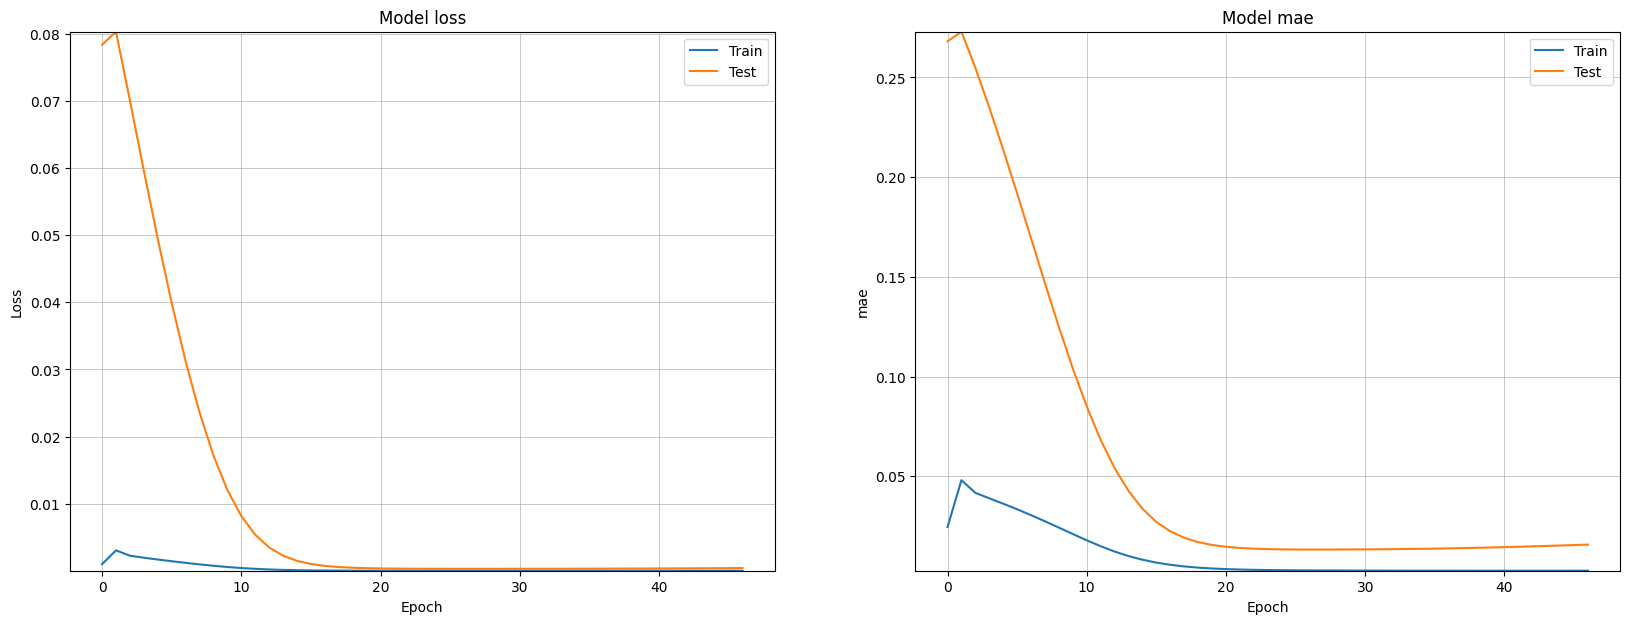

In [36]:
# Visualization of history
plot_loss_metric(history, 'mae')

### Evaluate model


In [37]:
# Evaluate model on unseen data (X_test)
model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011         


[0.002484719268977642, 0.002484719268977642, 0.04063228517770767]

### Predictions



In [38]:
# Predictions from unseen data
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [39]:
# Shape
print(f"Shape of y_pred : {y_test.shape}")

Shape of y_pred : (503,)


### Visualization


In [40]:
# Let's reshape the data
print(y_test.shape)
y_test = y_test.reshape(-1,1)
print(y_test.shape)
print("y_test has been reshaped.")

(503,)
(503, 1)
y_test has been reshaped.


In [41]:
# Let's reshape the data
print(y_train.shape)
y_train = y_train.reshape(-1,1)
print(y_train.shape)
print("y_train has been reshaped.")

(2012,)
(2012, 1)
y_train has been reshaped.


In [42]:
# Convert back to original price
y_test = minmax_scaler.inverse_transform(y_test)  
print("y_test converted back to original price.")

y_pred = minmax_scaler.inverse_transform(y_pred) 
print("y_pred converted back to original price.")

y_train = minmax_scaler.inverse_transform(y_train) 
print("y_train converted back to original price.")


y_test converted back to original price.
y_pred converted back to original price.
y_train converted back to original price.


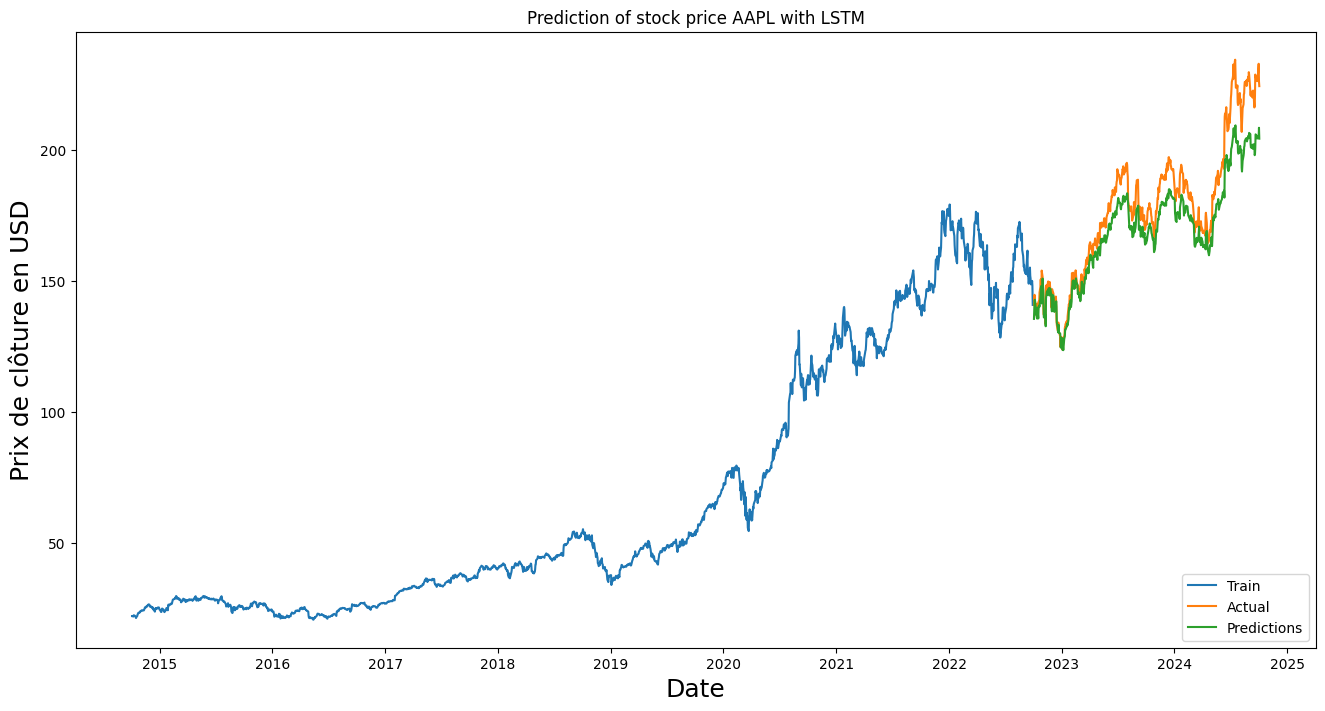

In [43]:
# Plot stock prices : actual vs predicted
plt.figure(figsize=(16,8))
plt.title(f'Prediction of stock price {ticker} with LSTM')
plt.plot(y_train_dates, y_train)
plt.plot(y_test_dates, y_test)
plt.plot(y_test_dates, y_pred)
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de clôture en USD', fontsize=18)
plt.show()


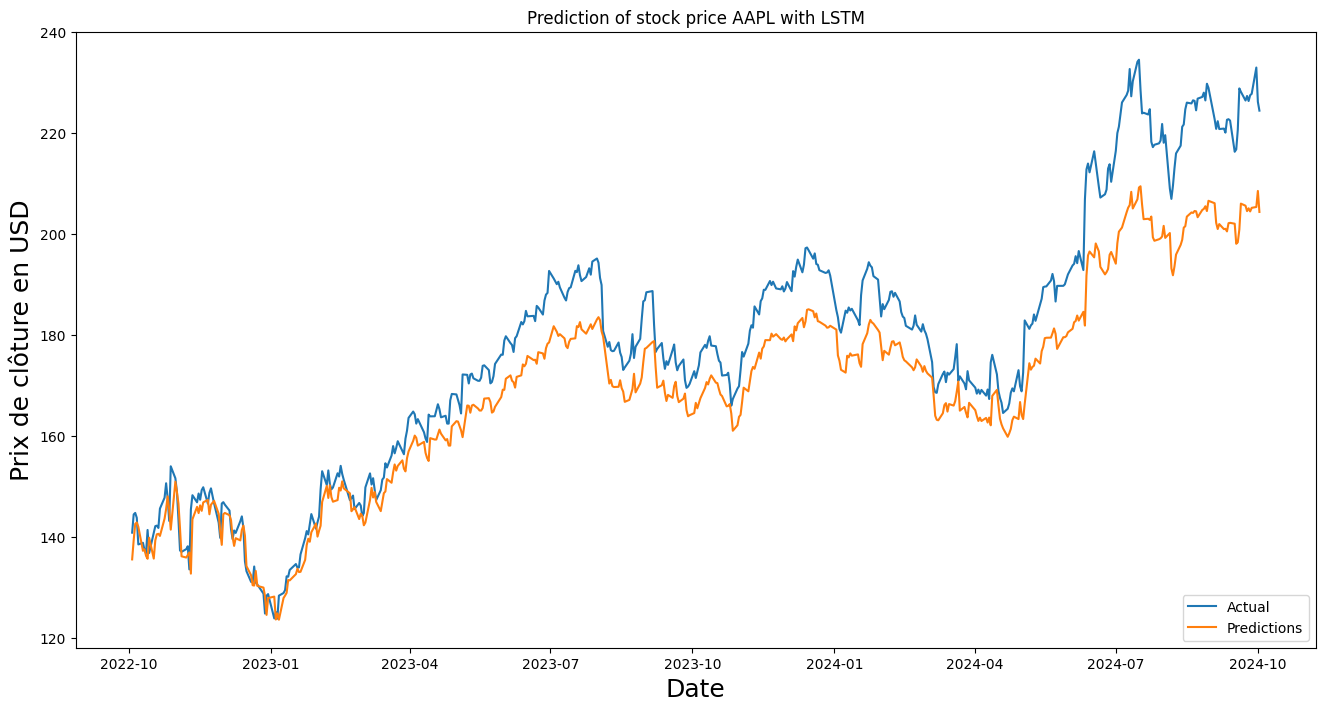

In [44]:
# Plot stock prices : actual vs predicted (ONLY predictions and actual. No train data displayed)
plt.figure(figsize=(16,8))
plt.title(f'Prediction of stock price {ticker} with LSTM')
plt.plot(y_test_dates, y_test)
plt.plot(y_test_dates, y_pred)
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de clôture en USD', fontsize=18)
plt.show()

In [45]:
# Display latest data (actual and predicted)
def retrieve_element(s):
    return s[0]

# Create Pandas dataframe with actual data and predicted data with time index
actual_and_pred = pd.DataFrame({'actual' : y_test.tolist(),
                                 'predictions' : y_pred.tolist()},
                                 index = y_test_dates)

# Formatting
actual_and_pred['actual'] = actual_and_pred['actual'].apply(retrieve_element)
actual_and_pred['predictions'] = actual_and_pred['predictions'].apply(retrieve_element)

# New column with absolute value of difference between actual and predicted values
actual_and_pred['diffrence'] = np.abs(actual_and_pred['actual'] - actual_and_pred['predictions'])

# Description of dataframe
actual_and_pred.describe()

,actual,predictions,diffrence
count,503.000000,503.000000,503.000000
mean,177.540054,169.048293,8.688339
std,25.810351,20.016071,6.180335
min,123.855095,123.646393,0.022858
25%,160.929054,156.183945,4.292656
50%,177.063934,169.898651,7.548981
75%,190.920517,180.380089,11.143494
max,234.548523,209.488464,27.948898
